# NEU-PCA
- Designed and Coded by: [Anastasis Kratsios](https://people.math.ethz.ch/~kratsioa/).
- Some Elements of the PCA analysis are forked from [this repo](https://github.com/radmerti/MVA2-PCA/blob/master/YieldCurvePCA.ipynb).

---
---
---
## About the Dataset:
All data is downloaded from the [US Federal reserve's online database](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll).

Data is downloaded on December $2^{nd}$ 2020 and the first yield curve is observed January $3^{nd}$ 1990.  

---
## About the Algorithm:
---
---
---

## Parameters

In [56]:
PCA_Rank = 4

## Imports

In [57]:
# First Round Initializations (Global Level) #
#============================================#
# Load Dependances and makes path(s)
exec(open('Initializations_Dump.py').read())
# Load Hyper( and meta) parameter(s)
exec(open('HyperParameter_Grid.py').read())
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
# %run Architecture_Builder.ipynb
exec(open('Architecture_Builder.py').read())
# Initialize "First Run Mode"
First_run = True

Parameter Grids Build and Loaded!
Complete NEU-Structure Building Procedure!!!
Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN (Fully Coupled) Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-PCA Training Procedure!!!


In [58]:
# # ## TEMPS!!
is_visuallty_verbose = True
# First_run = False

In [59]:
Train_step_proportion=.75

## Prepare Data

### Load Data

In [60]:
if First_run:
    # Load Data
    yield_data = pd.read_excel('inputs/data/ust_daily.ods', engine='odf')

#### Hardcore Maturities Vector

In [61]:
Maturities = np.array([(1/12),.25,.5,1,2,3,5,7,10,20,30])

### Format Data

In [62]:
if First_run:
    yield_data['date'] = pd.to_datetime(yield_data['date'],infer_datetime_format=True)
    yield_data.set_index('date', drop=True, inplace=True)
    yield_data.index.names = [None]
    # Remove garbage column
    yield_data.drop(columns=['BC_30YEARDISPLAY'])

### Sub-set Data

In [63]:
if First_run:
    # # Get indices
    N_train_step = int(round(yield_data.shape[0]*Train_step_proportion,0))
    N_test_set = int(yield_data.shape[0] - round(yield_data.shape[0]*Train_step_proportion,0))
    # # Get Datasets
    X_train = yield_data[:N_train_step]
    X_test = yield_data[-N_test_set:]
    # Transpose
    X_train_T = X_train.T
    X_test_T = X_test.T
    
    
    # # Update User
    print('#================================================#')
    print(' Training Datasize: '+str(X_train.shape[0])+' and test datasize: ' + str(X_test.shape[0]) + '.  ')
    print('#================================================#')
    
    # # Set First Run to Off
    First_run = False

#================================================#
 Training Datasize: 5126 and test datasize: 1708.  
#================================================#


# Data Visualization

## Tabular 

In [64]:
if is_visuallty_verbose:
    print('Training Dataset Preview:')
    print(X_train.head())

X_train.head()

Training Dataset Preview:
            BC_1MONTH  BC_3MONTH  BC_6MONTH  BC_1YEAR  BC_2YEAR  BC_3YEAR  \
1990-06-08        0.0       7.96       8.03      8.07      8.33      8.38   
1990-06-07        0.0       7.96       8.01      8.07      8.34      8.38   
1990-06-11        0.0       7.99       8.07      8.09      8.36      8.41   
1990-06-13        0.0       7.93       7.99      8.02      8.27      8.32   
1990-06-12        0.0       7.99       8.05      8.09      8.36      8.42   

            BC_5YEAR  BC_7YEAR  BC_10YEAR  BC_20YEAR  BC_30YEAR  \
1990-06-08      8.42      8.51       8.46        0.0       8.44   
1990-06-07      8.41      8.49       8.46        0.0       8.43   
1990-06-11      8.43      8.52       8.48        0.0       8.45   
1990-06-13      8.35      8.44       8.40        0.0       8.39   
1990-06-12      8.44      8.52       8.48        0.0       8.45   

            BC_30YEARDISPLAY  
1990-06-08               0.0  
1990-06-07               0.0  
1990-06-11     

,BC_1MONTH,BC_3MONTH,BC_6MONTH,BC_1YEAR,BC_2YEAR,BC_3YEAR,BC_5YEAR,BC_7YEAR,BC_10YEAR,BC_20YEAR,BC_30YEAR,BC_30YEARDISPLAY
1990-06-08,0.0,7.96,8.03,8.07,8.33,8.38,8.42,8.51,8.46,0.0,8.44,0.0
1990-06-07,0.0,7.96,8.01,8.07,8.34,8.38,8.41,8.49,8.46,0.0,8.43,0.0
1990-06-11,0.0,7.99,8.07,8.09,8.36,8.41,8.43,8.52,8.48,0.0,8.45,0.0
1990-06-13,0.0,7.93,7.99,8.02,8.27,8.32,8.35,8.44,8.40,0.0,8.39,0.0
1990-06-12,0.0,7.99,8.05,8.09,8.36,8.42,8.44,8.52,8.48,0.0,8.45,0.0


In [65]:
if is_visuallty_verbose:
    print('Testing Dataset Preview:')
    print(X_test.head())
    
X_test.head()

Testing Dataset Preview:
            BC_1MONTH  BC_3MONTH  BC_6MONTH  BC_1YEAR  BC_2YEAR  BC_3YEAR  \
2010-10-01       0.15       0.16       0.19      0.26      0.42      0.63   
2010-09-30       0.14       0.16       0.19      0.27      0.42      0.64   
2010-09-21       0.12       0.17       0.20      0.26      0.43      0.68   
2010-09-20       0.12       0.17       0.20      0.26      0.47      0.73   
2010-09-22       0.12       0.16       0.19      0.25      0.44      0.68   

            BC_5YEAR  BC_7YEAR  BC_10YEAR  BC_20YEAR  BC_30YEAR  \
2010-10-01      1.26      1.90       2.54       3.40       3.71   
2010-09-30      1.27      1.91       2.53       3.38       3.69   
2010-09-21      1.34      1.99       2.61       3.49       3.79   
2010-09-20      1.43      2.10       2.72       3.57       3.87   
2010-09-22      1.33      1.96       2.56       3.43       3.74   

            BC_30YEARDISPLAY  
2010-10-01               0.0  
2010-09-30               0.0  
2010-09-21      

,BC_1MONTH,BC_3MONTH,BC_6MONTH,BC_1YEAR,BC_2YEAR,BC_3YEAR,BC_5YEAR,BC_7YEAR,BC_10YEAR,BC_20YEAR,BC_30YEAR,BC_30YEARDISPLAY
2010-10-01,0.15,0.16,0.19,0.26,0.42,0.63,1.26,1.90,2.54,3.40,3.71,0.0
2010-09-30,0.14,0.16,0.19,0.27,0.42,0.64,1.27,1.91,2.53,3.38,3.69,0.0
2010-09-21,0.12,0.17,0.20,0.26,0.43,0.68,1.34,1.99,2.61,3.49,3.79,0.0
2010-09-20,0.12,0.17,0.20,0.26,0.47,0.73,1.43,2.10,2.72,3.57,3.87,0.0
2010-09-22,0.12,0.16,0.19,0.25,0.44,0.68,1.33,1.96,2.56,3.43,3.74,0.0


## Time-Series

/usr/lib64/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib64/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


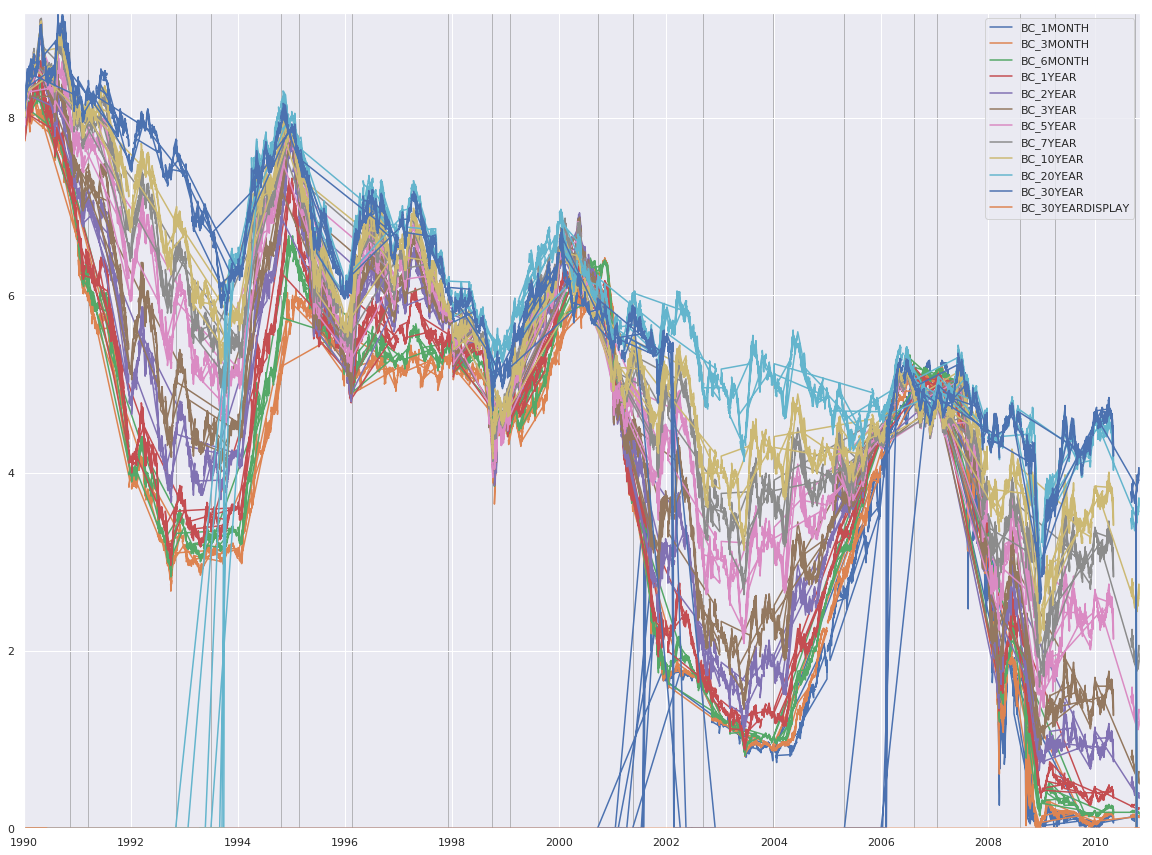

In [66]:
plt.figure(figsize=(20,15))

plt.plot(X_train.index, X_train)
plt.xlim(X_train.index.min(), X_train.index.max())
plt.ylim(np.min(X_train.min()),np.max(X_train.max()))

plt.axhline(y=0,c="grey",linewidth=0.5,zorder=0)
for i in range(X_train.index.min().year, X_train.index.max().year+1):
    plt.axvline(x=X_train.index[X_train.index.searchsorted(DT.datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)
    
plt.legend((np.array(X_train.columns)))

# Save 
plt.savefig('outputs/plotsANDfigures/Data_Visualization_Yield_TimeSeries.pdf')

## Curves

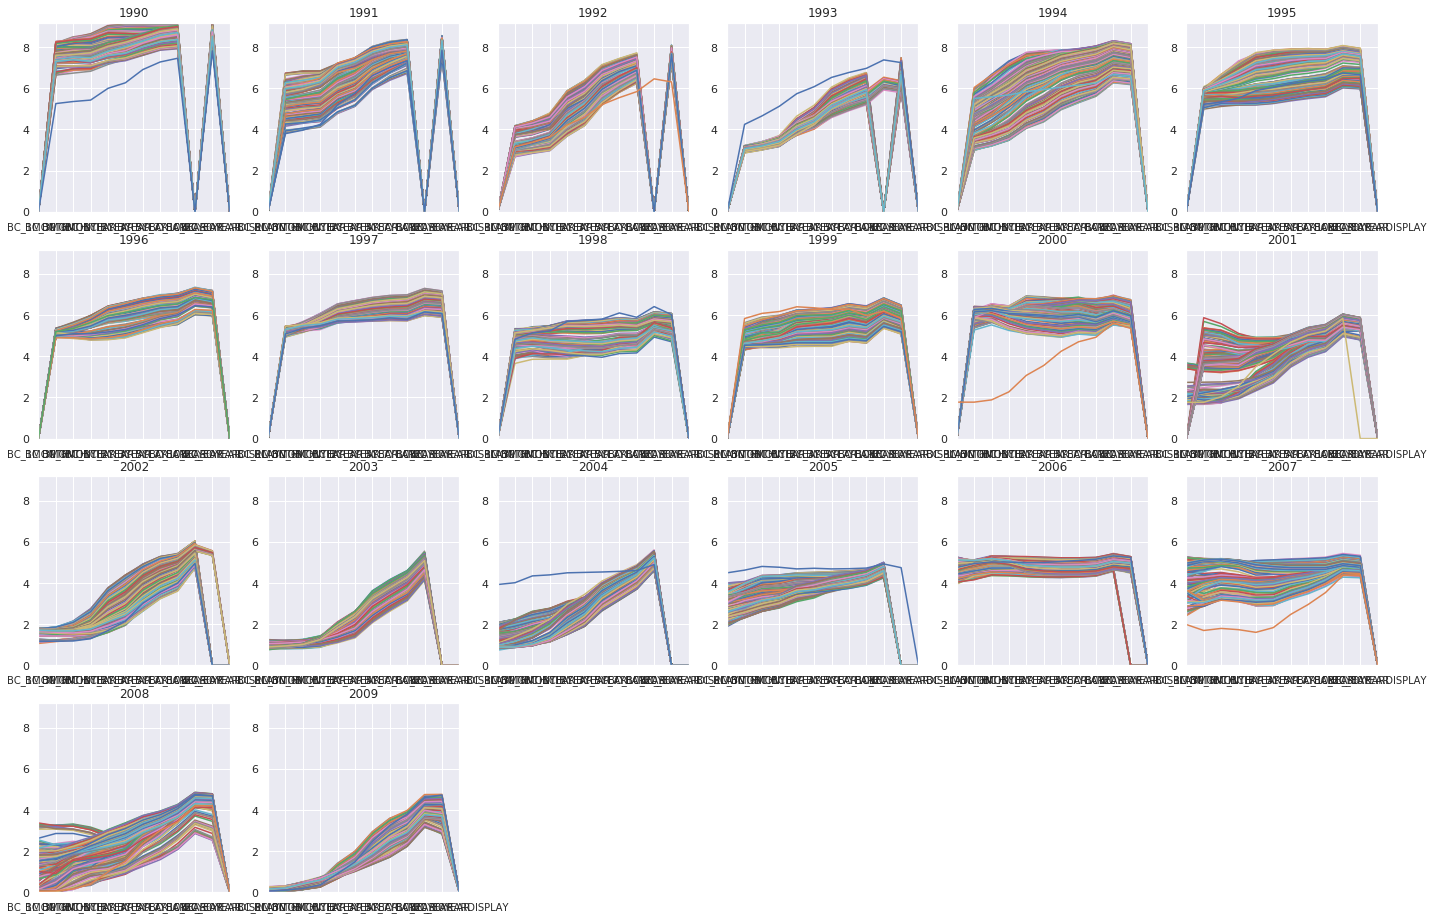

In [67]:
Ncols = 6
Nrows = 10
num_years = X_train.index.max().year-X_train.index.min().year
rows = math.ceil(num_years/Ncols)

plt.figure(figsize=(24,(24/Ncols)*rows))

plt.subplot2grid((rows,Ncols), (0,0), colspan=Ncols, rowspan=Nrows)


colnum = 0
rownum = 0
for year in range(X_train.index.min().year,X_train.index.max().year):
    year_start = X_train.index[X_train.index.searchsorted(DT.datetime(year,1,1))]
    year_end = X_train.index[X_train.index.searchsorted(DT.datetime(year,12,30))]
    
    plt.subplot2grid((rows,Ncols), (rownum,colnum), colspan=1, rowspan=1)
    plt.title('{0}'.format(year))
    plt.xlim(0, len(X_train_T.index)-1)
    plt.ylim(np.min(X_train_T.values), np.max(X_train_T.values))
    plt.xticks(range(len(X_train_T.index)), X_train_T.index, size='small')
    
    plt.plot(X_train_T.loc[:,year_start:year_end].values)
    
    if colnum != Ncols-1:
        colnum += 1
    else:
        colnum = 0
        rownum += 1

# Save
plt.savefig('outputs/plotsANDfigures/Data_Visualization_Annual_Yield_Curves.pdf')

---

### Fix Seeds for Reproducability

In [68]:
# Numpy
np.random.seed(2020)
# Tensorflow
tf.random.set_seed(2020)
# Python's Seed
random.seed(2020)

---

# Benchark(s)
---

## Perform PCA

### Get PCAs

In [69]:
# Compute/Initialize PCA
pca = PCA(n_components=PCA_Rank)
pca.fit(X_train)

# PCAs
PCAs = pd.DataFrame(pca.components_)
PCAs.columns = X_train.columns
PCAs = PCAs.T

# Define PCA Rreconstructor
def PCA_reconstructor(x_in):
    affine_parameterizer = np.matmul(pca.components_,(x_in-pca.mean_))
    low_dimensional_reconstructed = np.matmul(np.transpose(pca.components_), affine_parameterizer) + pca.mean_
    return low_dimensional_reconstructed

In [70]:
# Explained Variance of PCAs
Explained_Variance_PCAs = np.zeros(PCA_Rank)
# Get Explained Variances from PCAs
print("#======================================#")
print(" Explained Variances/Component")
for i,pc in enumerate(pca.explained_variance_ratio_):
    Explained_Variance_PCAs[i] = pc*100.0
    print(' {0}.\t{1:2.2f}%'.format(i+1,pc*100.0))

# Get Cumulative Explained Variance
Cum_Explained_Variance_PCAs = np.cumsum(Explained_Variance_PCAs)
print("#--------------------------------------#")
print(" ")
print("#--------------------------------------#")
print(" Cumulative Explained Variance (in %):")
print(" "+ str(Cum_Explained_Variance_PCAs))
print("#======================================#")

#======================================#
 Explained Variances/Component
 1.	71.96%
 2.	14.69%
 3.	7.89%
 4.	3.89%
#--------------------------------------#
 
#--------------------------------------#
 Cumulative Explained Variance (in %):
 [71.95860546 86.65219899 94.5410736  98.42668264]
#======================================#


### Principal Components

### Run once across entire dataset

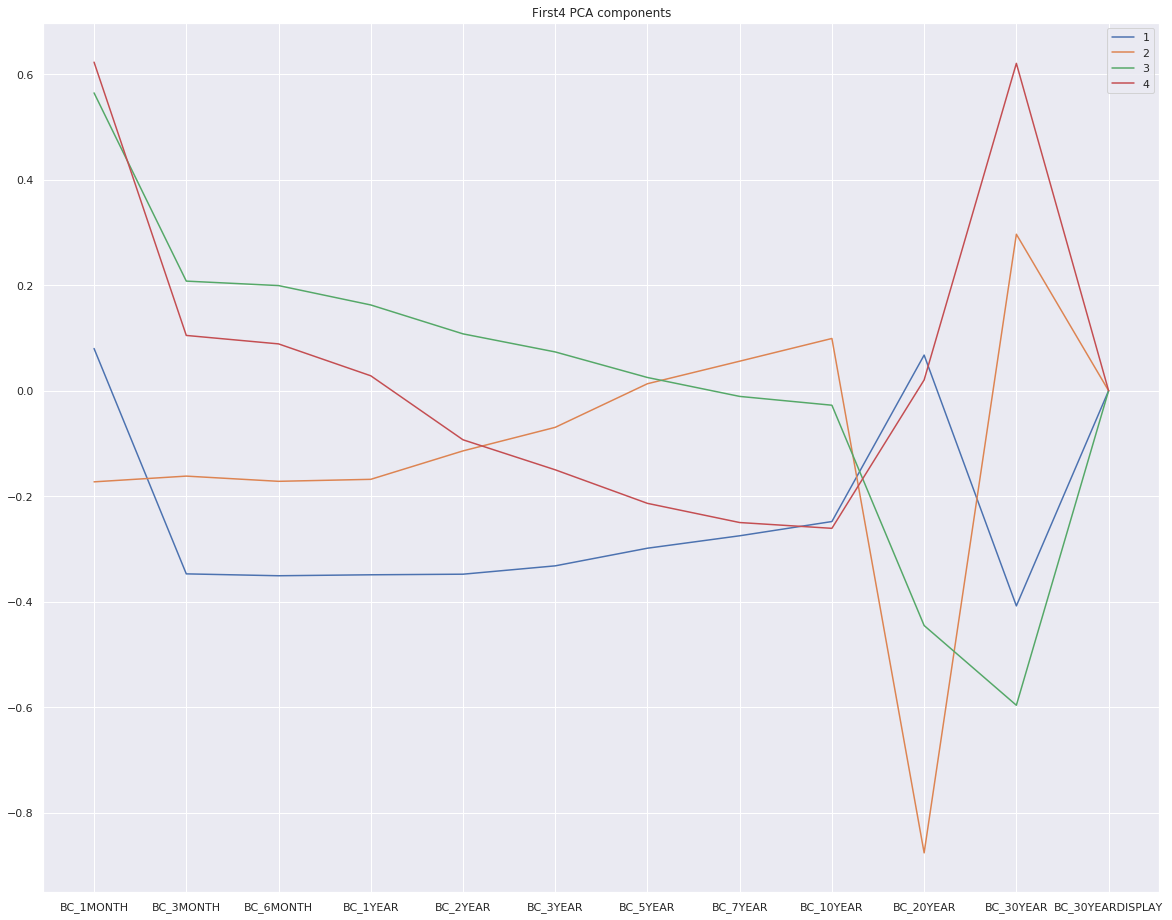

In [71]:
fig = plt.figure(figsize=(20,16))
plt.title('First' +str(PCA_Rank)+' PCA components')

plt.plot(PCAs)
plt.legend((np.array(PCAs.columns)+1))
# Save
plt.savefig('outputs/plotsANDfigures/PCAs.pdf')

### Run Annually

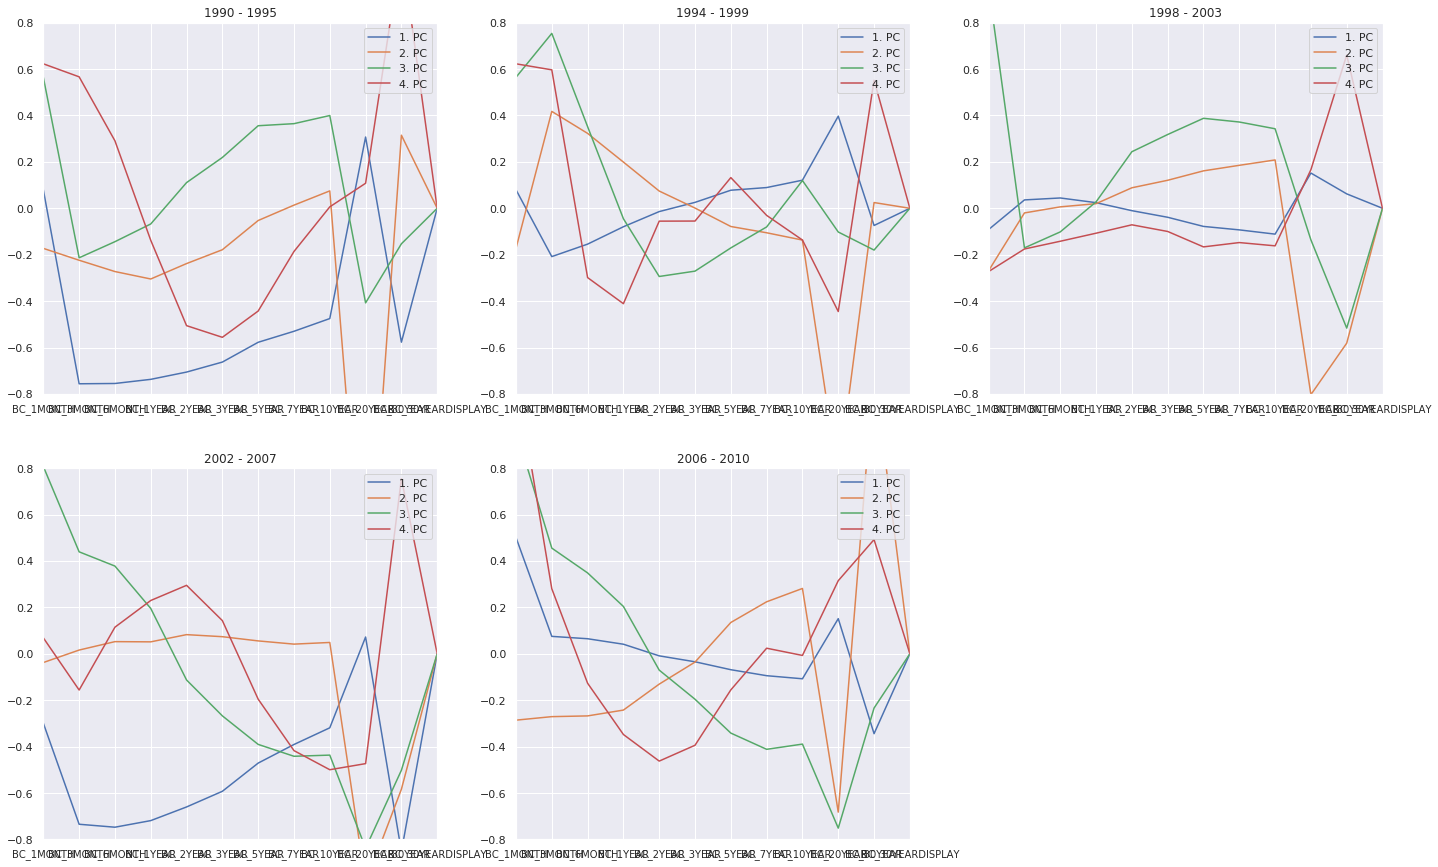

In [72]:
pca = PCA(n_components=PCA_Rank, copy=True, whiten=False)

merged_years = 4

cols = 3
num_years = X_train.index.max().year-X_train.index.min().year
rows = math.ceil(num_years/cols)

plt.figure(figsize=(24,(24/cols)*rows))

colnum = 0
rownum = 0
for year in range(X_train.index.min().year,X_train.index.max().year,merged_years):
    year_start = X_train.index[X_train.index.searchsorted(DT.datetime(year,1,1))]
    year_end = X_train.index[X_train.index.searchsorted(DT.datetime(np.minimum(year+merged_years,((X_train.index.max().year)-1)),12,31))]
    
    pca.fit(X_train.loc[year_start:year_end,:].values)
    pca_components = np.transpose(pca.components_)

    plt.subplot2grid((rows,cols), (rownum,colnum), colspan=1, rowspan=1)
    plt.title('{0} - {1}'.format(year_start.year, year_end.year))
    plt.xlim(0, len(pca_components)-1)
    plt.ylim(-0.8, 0.8)
    plt.xticks(range(len(pca_components)), X_train_T.index, size='small')
    plt.axhline(y=0,c="grey",linewidth=1.0,zorder=0)
    
    for i, comp in enumerate(pca.components_):
        plt.plot(PCAs[i]-comp, label='{0}. PC'.format(i+1))
        
    plt.legend(loc='upper right')
    
    if colnum != cols-1:
        colnum += 1
    else:
        colnum = 0
        rownum += 1

### Reconstruct Yield Curves - PCA

In [73]:
# Initialize
reconstructed_data_PCA_train = np.zeros(X_train.shape)
reconstructed_data_PCA_test = np.zeros(X_test.shape)
# Build Reconstructed Curves
## Training
for i in range(X_train.shape[0]):
    current_curve = np.array(X_train.iloc[i]).reshape(-1,)
    reconstructed_data_PCA_train[i,]=PCA_reconstructor(current_curve)
reconstructed_data_PCA_train = pd.DataFrame(reconstructed_data_PCA_train)
reconstructed_data_PCA_train.index = X_train.index
reconstructed_data_PCA_train.columns = X_train.columns
## Test
for i in range(X_test.shape[0]):
    current_curve = np.array(X_test.iloc[i]).reshape(-1,)
    reconstructed_data_PCA_test[i,]=PCA_reconstructor(current_curve)
reconstructed_data_PCA_test = pd.DataFrame(reconstructed_data_PCA_test)
reconstructed_data_PCA_test.index = X_test.index
reconstructed_data_PCA_test.columns = X_test.columns

### Get Performance Metric(s)

In [74]:
# PCA
## Absolute Errors
PCA_absolute_errors = np.mean(np.abs(reconstructed_data_PCA_train-X_train))
## Record Performance
PCA_performance = np.array([np.mean(PCA_absolute_errors),np.std(PCA_absolute_errors),np.mean(PCA_absolute_errors**2)])

# Get DataFrame
Performance_Metrics = pd.DataFrame({'PCA': PCA_performance},index = ['Abs. Rec. Err.','std. Rec. Err.','MS Rec. Err.'])

# Save
Performance_Metrics.to_latex('outputs/tables/Dim_redux_performance.tex')

# Update User
if is_visuallty_verbose:
    print(Performance_Metrics)
    
Performance_Metrics

                     PCA
Abs. Rec. Err.  0.466417
std. Rec. Err.  0.367788
MS Rec. Err.    0.352813


,PCA
Abs. Rec. Err.,0.466417
std. Rec. Err.,0.367788
MS Rec. Err.,0.352813


## Kernel-PCA

In [75]:
from sklearn.decomposition import KernelPCA

### Perform Kernel PCA
#### Across Entire Dataset

In [76]:
# Cross-Validate
## Initialize kPCA
kpca = KernelPCA(fit_inverse_transform=True, n_jobs=n_jobs,n_components=PCA_Rank)
## Perform Randomized Grid Search
randomized_grid_search = RandomizedSearchCV(kpca, kPCA_grid,cv=CV_folds, random_state=2020, scoring=MAE_reconstruction_score, n_iter=n_iter)
randomized_grid_search.fit(X_train)
kpca = randomized_grid_search.best_estimator_

#### Get kPCAs and Reconstruction

In [77]:
# First kernel Principal Components
kPCAs = pd.DataFrame(kpca.fit_transform(X_train_T),index=X_train.columns)

# Generate Prediction(s)
## Training
reconstructed_data_kPCA_train = pd.DataFrame(np.transpose(kpca.inverse_transform(kPCAs)))
reconstructed_data_kPCA_train.index = X_train.index
reconstructed_data_kPCA_train.columns = X_train.columns

## Get Performance

In [78]:
# PCA
## Absolute Errors
kPCA_absolute_errors = np.mean(np.abs(reconstructed_data_kPCA_train-X_train))
## Record Performance
kPCA_performance = np.array([np.mean(kPCA_absolute_errors),np.std(kPCA_absolute_errors),np.mean(kPCA_absolute_errors**2)])
kPCA_performance = pd.DataFrame({'kPCA': kPCA_performance},index = ['Abs. Rec. Err.','std. Rec. Err.','MS Rec. Err.'])


# Update DataFrame
Performance_Metrics = pd.concat([Performance_Metrics,kPCA_performance],axis=1)

# Save
Performance_Metrics.to_latex('outputs/tables/Dim_redux_performance.tex')

# Update User
if is_visuallty_verbose:
    print(Performance_Metrics)

                     PCA       kPCA
Abs. Rec. Err.  0.466417   3.941283
std. Rec. Err.  0.367788   0.053001
MS Rec. Err.    0.352813  15.536523


#### Visualize

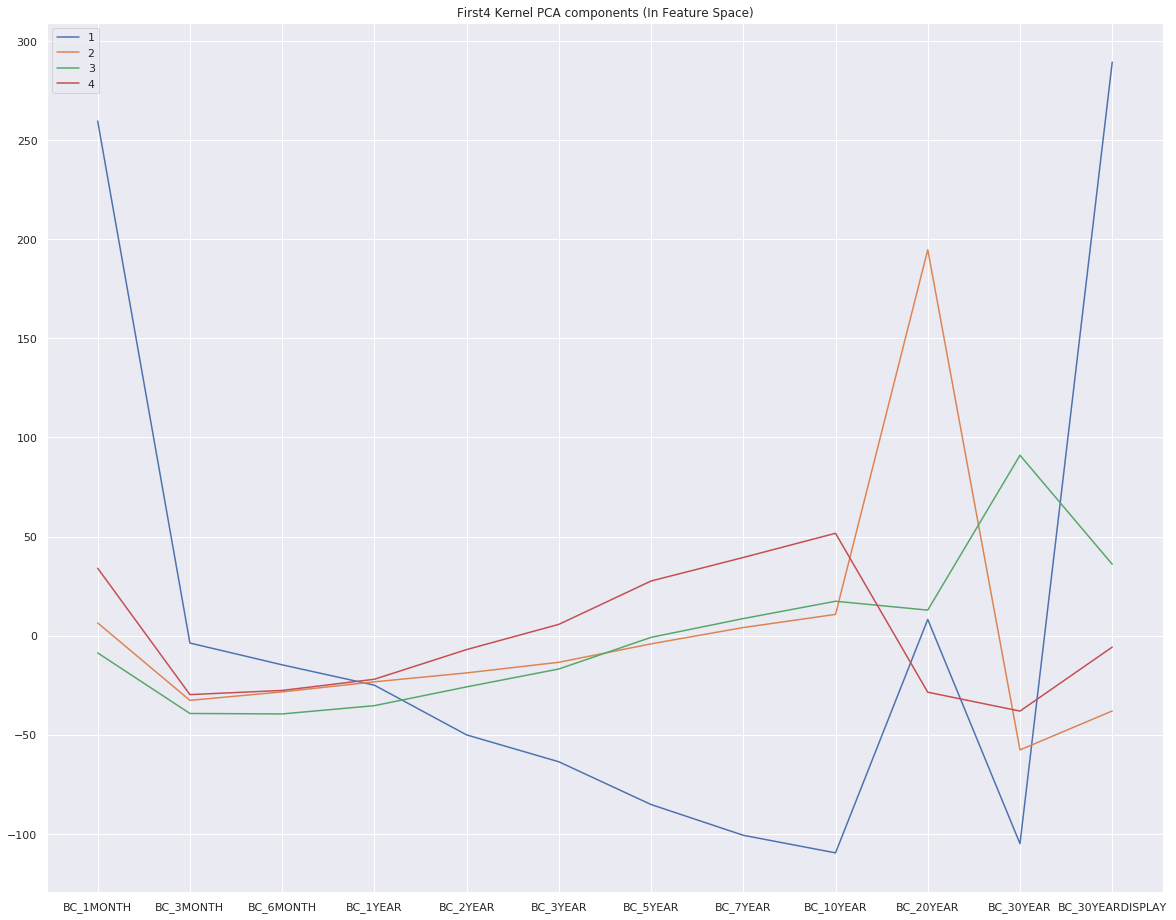

In [79]:
fig = plt.figure(figsize=(20,16))
plt.title('First' +str(PCA_Rank)+' Kernel PCA components (In Feature Space)')

plt.plot(kPCAs)
plt.legend((np.array(kPCAs.columns)+1))
# Save
plt.savefig('outputs/plotsANDfigures/Kernel_PCAs.pdf')

### Run once across entire dataset

In [80]:
print('HERE!!!: TBD')

HERE!!!: TBD


## Autoencoder

In [81]:
from numpy.random import seed

import sklearn
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
import scipy

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Layer, InputSpec
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import UnitNorm, Constraint

seed(2020)
tf.random.set_seed(2020)

#### Preprocess Data

In [82]:
# Initialize Scaler
scaler = MinMaxScaler()
scaler.fit(X_train)

# Train Scaler
X_train_scaled = scaler.transform(X_train).T
# Map to Test Set
X_test_scaled = scaler.transform(X_test).T

In [83]:
# Custom Layer

## Train Autoencoder

In [84]:
class DenseTied(tf.keras.layers.Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True
                
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

In [85]:
class WeightsOrthogonalityConstraint (tf.keras.constraints.Constraint):
    def __init__(self, encoding_dim, weightage = 1.0, axis = 0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
        self.axis = axis
        
    def weights_orthogonality(self, w):
        if(self.axis==1):
            w = tf.linalg.transpose(w)
        if(self.encoding_dim > 1):
            m = tf.reduce_sum(w*w) - tf.linalg.eye(self.encoding_dim)
            return self.weightage * tf.sqrt(tf.reduce_sum(tf.math.pow(m,2)))
        else:
            m = tf.sum(w ** 2) - 1.
            return m

    def __call__(self, w):
        return self.weights_orthogonality(w)

In [86]:
class UncorrelatedFeaturesConstraint (tf.keras.constraints.Constraint):

    def __init__(self, encoding_dim, weightage=1.0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage

    def get_covariance(self, x):
        x_centered_list = []

        for i in range(self.encoding_dim):
            x_centered_list.append(x[:, i] - K.mean(x[:, i]))

        x_centered = tf.stack(x_centered_list)
        covariance = K.dot(x_centered, K.transpose(x_centered)) / \
            tf.cast(x_centered.get_shape()[0], tf.float32)

        return covariance

    # Constraint penalty
    def uncorrelated_feature(self, x):
        if(self.encoding_dim <= 1):
            return 0.0
        else:
            output = K.sum(K.square(
                self.covariance - tf.math.multiply(self.covariance, K.eye(self.encoding_dim))))
            return output

    def __call__(self, x):
        self.covariance = self.get_covariance(x)
        return self.weightage * self.uncorrelated_feature(x)

In [87]:
# TEMP
nb_epoch = 200
batch_size = 16
input_dim = X_train_scaled.shape[1] #num of predictor variables, 
depth = 1
height = 50
learning_rate = 0.001
# CODE IN
Encoder_depth = depth + 1

In [88]:
#--------------------------------------------------#
# Build Regular Arch.
#--------------------------------------------------#
#-###################-#
# Define Model Input -#
#-###################-#
input_layer = tf.keras.Input(shape=(input_dim,))


#----------------------#
# Core Layers: Encoder #
#----------------------#
# PCA Readout (Really this is the OLS model)
encoder = fullyConnected_Dense(height)(input_layer)
encoder = tf.nn.relu(encoder)
encoder = fullyConnected_Dense(PCA_Rank)(encoder)


#----------------------#
# Core Layers: Decoder #
#----------------------#
# PCA Readout (Really this is the OLS model)
decoder = fullyConnected_Dense(PCA_Rank)(encoder)
decoder = tf.nn.relu(decoder)
decoder = fullyConnected_Dense(input_dim)(decoder)



# Define Input/Output Relationship (Arch.)
autoencoder_Vanilla = tf.keras.Model(input_layer, decoder)
#--------------------------------------------------#
# Define Optimizer & Compile Archs.
#----------------------------------#
opt = Adam(lr=learning_rate)
autoencoder_Vanilla.compile(metrics=['accuracy'],loss='mean_squared_error',optimizer='Adam')

In [89]:
Encoder_depth

2

In [90]:
# to codein
Encoder_depth = depth + 2

autoencoder_Vanilla.fit(X_train_scaled, X_train_scaled,
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                verbose=0)

# # Extract Auto-Encoder Layer
encoder_layer = Model(inputs=autoencoder_Vanilla.inputs, outputs=autoencoder_Vanilla.layers[Encoder_depth].output)
# Get Feature(s)
# ## Train
AE_Factors_train = np.array(encoder_layer.predict(X_train_scaled))
# Get Reconstruction(s)
## Test
AE_Reconstructed_train = pd.DataFrame(autoencoder_Vanilla.predict(X_train_scaled),columns=X_train_T.columns,index=X_train_T.index)
# AE_Reconstructed_test = autoencoder.predict(X_test_scaled)

# Visualize Results

### Factors

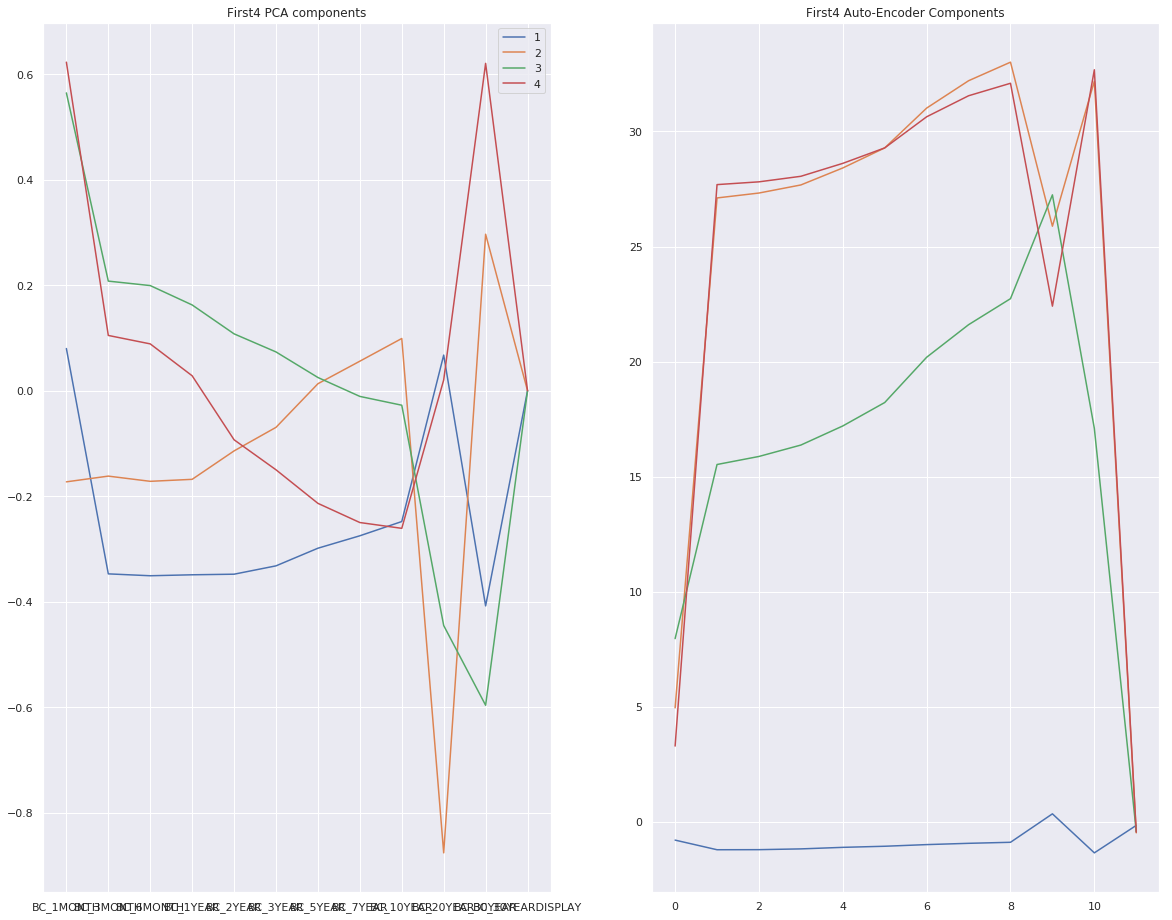

In [91]:
fig = plt.figure(figsize=(20,16))

#-----------------------------------------------------------#
# Plot PCA
plt.subplot(1,2,1)
plt.title('First' +str(PCA_Rank)+' PCA components')
plt.plot(PCAs)
plt.legend((np.array(PCAs.columns)+1))
#-----------------------------------------------------------#

#-----------------------------------------------------------#
# Plot kPCA (TBD)
##
#-----------------------------------------------------------#

#-----------------------------------------------------------#
# Plot AE
plt.subplot(1,2,2)
plt.title('First' +str(PCA_Rank)+' Auto-Encoder Components')
plt.plot(AE_Factors_train)
# plt.legend((np.array(AE_Factors.columns)+1))
#-----------------------------------------------------------#

#------#
# Save #
#------#
plt.savefig('outputs/plotsANDfigures/PCAs.pdf')

## Reconstruction

In [92]:
# PCA
## Absolute Errors
AE_absolute_errors = np.mean(np.abs(AE_Reconstructed_train-X_train_T))
## Record Performance
AE_performance = np.array([np.mean(AE_absolute_errors),np.std(AE_absolute_errors),np.mean(AE_absolute_errors**2)])
AE_performance = pd.DataFrame({'AE': AE_performance},index = ['Abs. Rec. Err.','std. Rec. Err.','MS Rec. Err.'])


# Update DataFrame
Performance_Metrics = pd.concat([Performance_Metrics,AE_performance],axis=1)

# Save
Performance_Metrics.to_latex('outputs/tables/Dim_redux_performance.tex')

# Update User
if is_visuallty_verbose:
    print(Performance_Metrics)

                     PCA       kPCA         AE
Abs. Rec. Err.  0.466417   3.941283   3.540919
std. Rec. Err.  0.367788   0.053001   1.183019
MS Rec. Err.    0.352813  15.536523  13.937643


In [93]:
AE_Reconstructed_train
X_train_T

,1990-06-08,1990-06-07,1990-06-11,1990-06-13,1990-06-12,1990-06-01,1990-05-31,1990-06-04,1990-06-06,1990-06-05,...,2010-09-17,2010-09-16,2010-09-07,2010-09-03,2010-09-08,2010-09-10,2010-09-09,2010-09-28,2010-09-27,2010-09-29
BC_1MONTH,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.12,0.12,0.13,0.15,0.10,0.10,0.10,0.08,0.08,0.12
BC_3MONTH,7.96,7.96,7.99,7.93,7.99,7.94,8.01,7.96,7.96,7.96,...,0.16,0.16,0.14,0.14,0.14,0.14,0.14,0.16,0.16,0.16
BC_6MONTH,8.03,8.01,8.07,7.99,8.05,8.01,8.12,8.03,8.02,8.03,...,0.20,0.20,0.18,0.19,0.19,0.19,0.19,0.20,0.19,0.20
BC_1YEAR,8.07,8.07,8.09,8.02,8.09,8.06,8.22,8.07,8.09,8.09,...,0.26,0.25,0.25,0.25,0.24,0.27,0.26,0.26,0.26,0.27
BC_2YEAR,8.33,8.34,8.36,8.27,8.36,8.33,8.50,8.31,8.34,8.34,...,0.48,0.48,0.49,0.52,0.52,0.58,0.57,0.37,0.44,0.44
BC_3YEAR,8.38,8.38,8.41,8.32,8.42,8.36,8.53,8.36,8.40,8.38,...,0.75,0.77,0.77,0.81,0.80,0.88,0.87,0.64,0.66,0.67
BC_5YEAR,8.42,8.41,8.43,8.35,8.44,8.38,8.56,8.39,8.43,8.42,...,1.46,1.48,1.41,1.49,1.46,1.59,1.57,1.25,1.31,1.28
BC_7YEAR,8.51,8.49,8.52,8.44,8.52,8.47,8.64,8.47,8.51,8.51,...,2.14,2.17,2.04,2.14,2.09,2.24,2.20,1.85,1.92,1.91
BC_10YEAR,8.46,8.46,8.48,8.40,8.48,8.44,8.60,8.44,8.46,8.47,...,2.75,2.77,2.61,2.72,2.66,2.81,2.77,2.48,2.54,2.52
BC_20YEAR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.60,3.61,3.37,3.49,3.42,3.58,3.54,3.35,3.40,3.38


---

## Summary

In [94]:
# Update User
if is_visuallty_verbose:
    print(Performance_Metrics)
    
Performance_Metrics

                     PCA       kPCA         AE
Abs. Rec. Err.  0.466417   3.941283   3.540919
std. Rec. Err.  0.367788   0.053001   1.183019
MS Rec. Err.    0.352813  15.536523  13.937643


,PCA,kPCA,AE
Abs. Rec. Err.,0.466417,3.941283,3.540919
std. Rec. Err.,0.367788,0.053001,1.183019
MS Rec. Err.,0.352813,15.536523,13.937643


---
# Fin
---